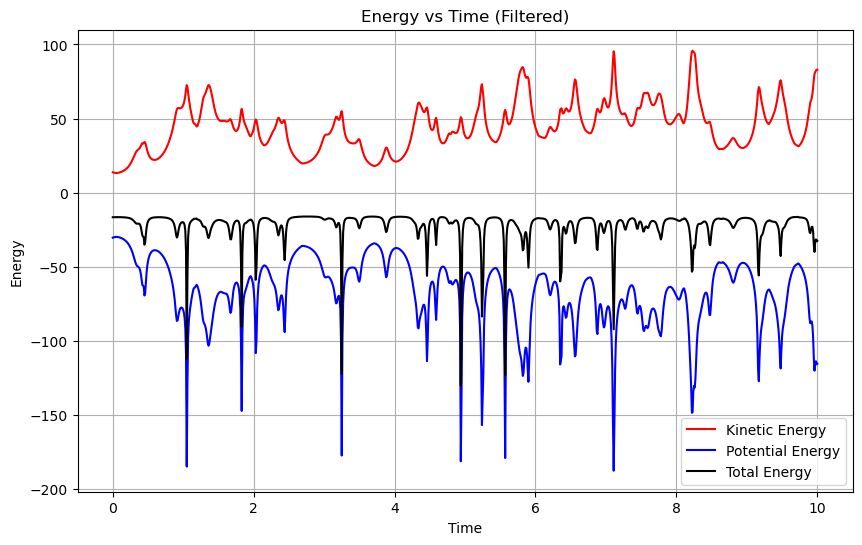

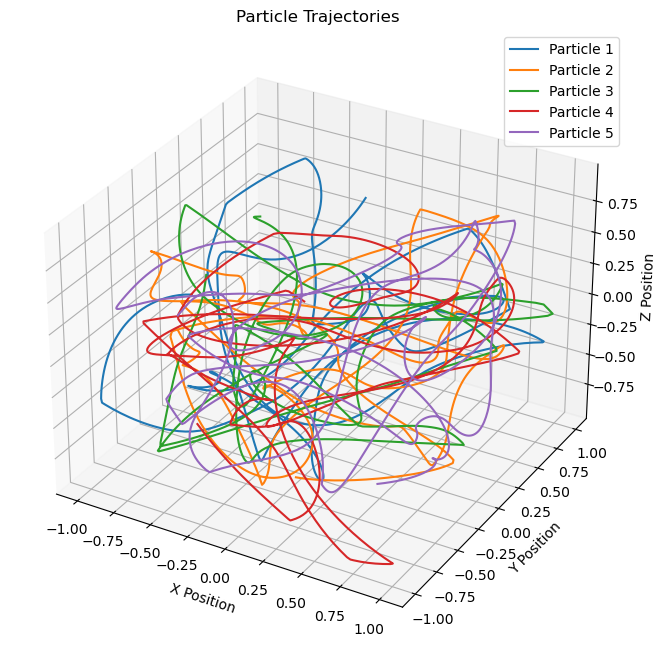

In [1]:
import matplotlib
%matplotlib inline
import utils as ut
import importlib
import models.E3NN_EGCNN.GNN_utils as GNN_utils
import torch
from datetime import datetime
import os
from torch.utils.tensorboard import SummaryWriter
import utils.loggers as loggers
import torch.nn as torch_nn
import models.E3NN_EGCNN.GNN_models as GNN_models
from e3nn.nn.models.v2106.gate_points_networks import SimpleNetwork

importlib.reload(ut)

seed_value = 42

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

N = 5  # Number of particles
tEnd = 10.0  # time at which simulation ends
dt = 0.01  # timestep
softening = 0.15  # softening length
G = 1.0  # Newton's Gravitational Constant
boxSize = 1.0
mass_coef = 10.0
dims = 3

combined_data = ut.simulate_gravitational_system(seed_value, N, tEnd, dt, softening, G, boxSize, mass_coef, dims=dims,
                                                 init_boxsize=boxSize)

LOG_WANDB = False
t_delta = 10  # how many steps ahead to predict
L_MAX = 1
batch_size = 32
MAX_RADIUS = (boxSize ** 2 + boxSize ** 2 + boxSize ** 2) ** 0.5
NUMBER_OF_BASIS = 10
lr = 1e-2
#lr = 0.005
weight_decay = 0.05
scheduler_gamma = 1
#scheduler_gamma = 0.5

hparams = {
    'N': N,  # Number of particles
    'tEnd': tEnd,  # Time at which simulation ends
    'dt': dt,  # Timestep
    'G': G,  # Newton's Gravitational Constant
    'boxSize': boxSize,  # Size of the simulation box
    'mass_coef': mass_coef,  # Mass coefficient
    'lr': lr
}

model_dict = {
    "irreps_in": "1x1o",
    "irreps_out": "2x1o",
    "layers": 3,
    "mul": 32,
    "lmax": L_MAX,  # Assuming L_MAX is defined elsewhere
    "max_radius": MAX_RADIUS,  # Assuming MAX_RADIUS is defined elsewhere
    "num_neighbors": N - 1,  # Assuming N is defined elsewhere
    "reduce_output": False,
    "number_of_basis": 10,
    "radial_layers": 3,
    "radial_neurons": 200,
    "num_nodes": 1.,
    "fully_connected": True
}

hparams.update(model_dict)

#experiment
current_time = datetime.now().strftime('%Y-%m-%d %H-%M')
experiment_name = "e3nn_nbody_EGCN"
run_name = current_time + "_" + "_".join(str(value) for value in hparams.values())
experiment_folder = os.path.join(experiment_name, run_name)
writer = SummaryWriter(experiment_folder)

loggers_list = [loggers.TensorBoardLogger(writer)]


combined_data shape: (999, 5, 6)
inputs_np shape: (989, 5, 6)
targets_np shape: (989, 5, 6)


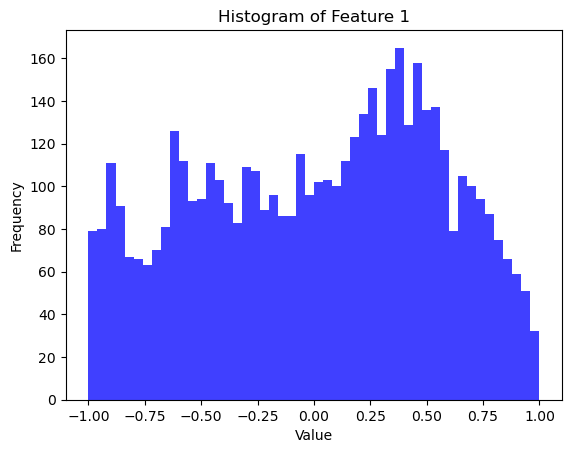

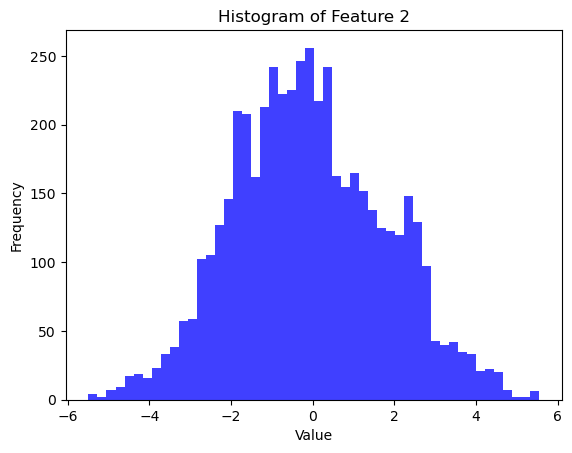

In [2]:
inputs_np, targets_np = ut.process_data(combined_data, dims=dims, t_delta=t_delta, apply_normalization=False)

# Dataloader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
data_loader = GNN_utils.create_n_body_graph_dataset(inputs_np, targets_np, batch_size=batch_size, dims=dims,
                                                    max_radius=MAX_RADIUS,
                                                    num_basis=NUMBER_OF_BASIS)

cpu


# GCN with fairy dust and all the fancy stuff..

In [4]:
model_dict = {
    "irreps_in": "1x1o",
    "irreps_out": "2x1o",
    "layers": 3,
    "mul": 32,
    "lmax": L_MAX,  # Assuming L_MAX is defined elsewhere
    "max_radius": MAX_RADIUS,  # Assuming MAX_RADIUS is defined elsewhere
    "num_neighbors": N - 1,  # Assuming N is defined elsewhere
    "number_of_basis": 10,
    "mlp_layers": [100],
    "num_nodes": 1.,
    "fully_connected": True,
    "pool_nodes": False
}

# model = SimpleNetwork(
#     model_dict["irreps_in"],
#     model_dict["irreps_out"],
#     model_dict["max_radius"],
#     model_dict["num_neighbors"],
#                               1,
#                               mul=50,
#                               layers=3,
#                               lmax=2,
#                               pool_nodes=False,)

model = GNN_models.SimpleNetworkCustom(**model_dict)

C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3\lib\site-packages\torch\jit\_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base type

In [5]:
#GNN_utils.visualize_layers(model)

In [6]:
print(model)

SimpleNetworkCustom(
  (mp): MessagePassing(
    (layers): ModuleList(
      (0): Compose(
        (first): Convolution(
          (sc): FullyConnectedTensorProduct(1x1o x 1x0e -> 96x0e+32x1o+32x1e | 32 paths | 32 weights)
          (lin1): FullyConnectedTensorProduct(1x1o x 1x0e -> 1x1o | 1 paths | 1 weights)
          (fc): FullyConnectedNet[10, 100, 3]
          (tp): TensorProduct(1x1o x 1x0e+1x1o -> 1x0e+1x1o+1x1e | 3 paths | 3 weights)
          (lin2): FullyConnectedTensorProduct(1x0e+1x1o+1x1e x 1x0e -> 96x0e+32x1o+32x1e | 160 paths | 160 weights)
          (alpha): FullyConnectedTensorProduct(1x0e+1x1o+1x1e x 1x0e -> 1x0e | 1 paths | 1 weights)
        )
        (second): Gate (96x0e+32x1o+32x1e -> 32x0e+32x1o+32x1e)
      )
      (1): Compose(
        (first): Convolution(
          (sc): FullyConnectedTensorProduct(32x0e+32x1o+32x1e x 1x0e -> 32x0o+96x0e+32x1o+32x1e | 5120 paths | 5120 weights)
          (lin1): FullyConnectedTensorProduct(32x0e+32x1o+32x1e x 1x0e -> 32x0e+3

# EQUIVARIANCE TEST

In [12]:
import importlib

importlib.reload(GNN_utils)
GNN_utils.equivariance_test(model, data_loader)

False
tensor(23.1261, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)


tensor(0.0003, grad_fn=<MeanBackward0>)

In [8]:
from e3nn.util.test import assert_equivariant, assert_auto_jitable


def test_ekviv(model, data_loader):
    databatch = data_loader.dataset[1]
    mp = model.mp
    batch, node_features, node_attr, edge_src, edge_dst, edge_vec, edge_attr, edge_scalars = model.preprocess(databatch)

    assert mp(node_features, node_attr, edge_src, edge_dst, edge_attr, edge_scalars).shape == databatch.y.shape

    # perform N trials and returns max trials for each parity
    errors = assert_equivariant(
        mp,
        irreps_in=[mp.irreps_node_input, mp.irreps_node_attr, None, None, mp.irreps_edge_attr, None],
        args_in=[node_features, node_attr, edge_src, edge_dst, edge_attr, edge_scalars],
        irreps_out=[mp.irreps_node_output],
        ntrials=5
    )
    return max(errors.values())

    #jitable_errrors = assert_auto_jitable(mp.layers[0].first)
# Hyperparam testing
#from tensorboardX import SummaryWriter

session_num = 0


def log_experiment(run_name, hparams, metric):
    """
    Log an experiment to TensorBoard.

    Args:
    - run_name: Name of the run (e.g., 'run-1').
    - params: Dict of hyperparameters (e.g., {'lr': 0.01, 'batch_size': 32}).
    - metric: Dict of metrics (e.g., {'accuracy': 0.95}).
    """
    # with SummaryWriter(log_dir=f'runs/{run_name}') as writer:
    #     for k, v in params.items():
    #         writer.add_text('hparams/' + k, str(v), 0)
    #     for k, v in metric.items():
    #         writer.add_scalar('metrics/' + k, v, 0)

    with SummaryWriter(log_dir=f'runs_myown/{run_name}') as writer:
        print(writer.get_logdir())
        writer.add_hparams(hparams, metric)
        for key, value in hparams.items():
            if isinstance(value, (int, float)):
                writer.add_scalar(key, value)

# 
for layers in [1, 10, 30]:
    for mlp_layers in [[10], [100], [100, 100]]:
        print(layers, mlp_layers)
        model_dict = {
            "irreps_in": "1x1o",
            "irreps_out": "2x1o",
            "layers": layers,
            "mul": 32,
            "lmax": L_MAX,  # Assuming L_MAX is defined elsewhere
            "max_radius": MAX_RADIUS,  # Assuming MAX_RADIUS is defined elsewhere
            "num_neighbors": N - 1,  # Assuming N is defined elsewhere
            "number_of_basis": 10,
            "mlp_layers": mlp_layers,
            "num_nodes": 1.,
            "fully_connected": True,
            "pool_nodes": False
        }

        model = GNN_models.SimpleNetworkCustom(**model_dict)

        #error = test_ekviv(model, data_loader)
        error = GNN_utils.equivariance_test(model, data_loader)

        # Example usage
        log_experiment(f'run-{str(session_num)}', {'layers': layers, 'mlp_layers': str(mlp_layers)},
                       {'equivariance_error': error})
        session_num += 1

1 [10]
True
tensor(1.6209, grad_fn=<MeanBackward0>)
tensor(2.7938e-06, grad_fn=<MeanBackward0>)
runs_myown/run-0
1 [100]
True
tensor(1.3397, grad_fn=<MeanBackward0>)
tensor(6.6145e-07, grad_fn=<MeanBackward0>)
runs_myown/run-1
1 [100, 100]
True
tensor(0.7841, grad_fn=<MeanBackward0>)
tensor(1.0160e-06, grad_fn=<MeanBackward0>)
runs_myown/run-2
10 [10]
False
tensor(5.2503, grad_fn=<MeanBackward0>)
tensor(1.3832e-05, grad_fn=<MeanBackward0>)
runs_myown/run-3
10 [100]
True
tensor(0.4379, grad_fn=<MeanBackward0>)
tensor(2.5868e-07, grad_fn=<MeanBackward0>)
runs_myown/run-4
10 [100, 100]
True
tensor(0.8234, grad_fn=<MeanBackward0>)
tensor(4.3601e-06, grad_fn=<MeanBackward0>)
runs_myown/run-5
30 [10]
False
tensor(131.5390, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
runs_myown/run-6
30 [100]
False
tensor(102.0251, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
runs_myown/run-7
30 [100, 100]
False
tensor(166.9726, grad_fn=<MeanBackward0>)
tensor(0.0025, 